In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

class NeuralMultiTaskModel(nn.Module):
    def __init__(self, structure, bins=100, dropout_rate=0.5, l2_lambda=0.01, auto_scaler=True):
        """
        Multi-task neural network model.

        :param structure: List defining the architecture of hidden layers (units, activations).
        :param bins: Number of time bins.
        :param dropout_rate: Dropout rate for regularization.
        :param l2_lambda: L2 regularization factor.
        :param auto_scaler: Whether to apply automatic scaling to input data.
        """
        super(NeuralMultiTaskModel, self).__init__()
        self.structure = structure
        self.bins = bins
        self.num_times = bins - 1
        self.dropout_rate = dropout_rate
        self.l2_lambda = l2_lambda
        self.auto_scaler = auto_scaler
        self.scaler = StandardScaler() if auto_scaler else None

        self.shared_layers = self.build_shared_layers(structure)
        self.output_layer = nn.Linear(structure[-1]['num_units'], self.num_times + 1)
        self.sigmoid = nn.Sigmoid()

    def build_shared_layers(self, structure):
        layers = []
        for layer in structure:
            layers.append(nn.Linear(layer['input_dim'], layer['num_units']))
            layers.append(self.get_activation_function(layer['activation']))
            layers.append(nn.Dropout(self.dropout_rate))
        return nn.Sequential(*layers)

    def get_activation_function(self, name):
        return {
            'relu': nn.ReLU(),
            'tanh': nn.Tanh(),
            'sigmoid': nn.Sigmoid()
        }.get(name.lower(), nn.ReLU())

    def forward(self, x):
        x = self.shared_layers(x)
        x = self.output_layer(x)
        x = self.sigmoid(x)
        return x

    def loss_function(self, Triangle, l2_reg, l2_smooth):
        def custom_loss(y_true, y_pred):
            num_times = self.num_times
            Y_cens = y_true[:, :num_times + 1]  # Censored data
            Y_uncens = y_true[:, num_times + 1:]  # Uncensored data

            # Ensure y_pred and Triangle dimensions are compatible
            if Y_cens.size(1) != y_pred.size(1):
                raise ValueError(f"Shape mismatch: Y_cens: {Y_cens.size()}, y_pred: {y_pred.size()}")

            phi = torch.exp(torch.matmul(y_pred, Triangle))

            if Y_cens.size(1) != phi.size(1) or Y_uncens.size(1) != phi.size(1):
                raise ValueError(f"Shape mismatch: Y_cens: {Y_cens.size()}, Y_uncens: {Y_uncens.size()}, phi: {phi.size()}")

            # Uncensored data loss
            loss_uncens = torch.sum(torch.sum(phi * Y_uncens, axis=1))

            # Censored data loss
            loss_cens = torch.sum(torch.sum(phi * Y_cens, axis=1))

            # Regularization
            reg_loss = torch.tensor(0.0)
            for param in self.parameters():
                reg_loss += l2_reg * torch.sum(param ** 2) / 2.0
                reg_loss += l2_smooth * torch.sum((param[:-1] - param[1:]) ** 2) / 2.0

            # Total loss
            loss = -(loss_uncens + loss_cens + reg_loss)
            return loss
        return custom_loss

    def fit(self, X, T, Triangle, epochs=1000, batch_size=32, lr=1e-5, validation_split=0.2):
        optimizer = optim.Adam(self.parameters(), lr=lr)
        criterion = self.loss_function(Triangle=Triangle, l2_reg=self.l2_lambda, l2_smooth=0.01)

        X_train, X_val, Y_train, Y_val = train_test_split(X, T, test_size=validation_split, random_state=42)

        train_losses, val_losses = [], []

        for epoch in range(epochs):
            self.train()
            optimizer.zero_grad()

            outputs = self(X_train)
            loss = criterion(Y_train, outputs)
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

            # Validation
            self.eval()
            with torch.no_grad():
                val_outputs = self(X_val)
                val_loss = criterion(Y_val, val_outputs)
                val_losses.append(val_loss.item())

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {loss.item()}, Val Loss: {val_loss.item()}")

        self.plot_loss(train_losses, val_losses)

    def plot_loss(self, train_losses, val_losses):
        plt.plot(train_losses, label='Train Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

    def predict(self, x, Triangle):
        self.eval()
        with torch.no_grad():
            scores = self(x)
            phi = torch.exp(torch.matmul(scores, Triangle))

            div = torch.sum(phi, 1, keepdim=True)
            density = phi / div
            Survival = torch.matmul(density, torch.tril(torch.ones(self.num_times + 1, self.num_times + 1)))

        return density, Survival

    def evaluate(self, X, T, Triangle):
        density, Survival = self.predict(X, Triangle)
        risk = 1 - Survival[:, -1]

        # Add further metrics or evaluations as needed
        return risk


Epoch 0, Loss: -1.45984864649216e+16, Val Loss: -3575436793610240.0
Epoch 100, Loss: -1.5369413767200768e+16, Val Loss: -3775230082285568.0
Epoch 200, Loss: -1.6633665308065792e+16, Val Loss: -3996734430642176.0
Epoch 300, Loss: -1.7857176936644608e+16, Val Loss: -4252038024134656.0
Epoch 400, Loss: -1.9280834041217024e+16, Val Loss: -4564917264842752.0
Epoch 500, Loss: -2.1327901353836544e+16, Val Loss: -4968639358828544.0
Epoch 600, Loss: -2.3744561339695104e+16, Val Loss: -5515109522735104.0
Epoch 700, Loss: -2.790900672705331e+16, Val Loss: -6289528633425920.0
Epoch 800, Loss: -3.4118709098315776e+16, Val Loss: -7450806185885696.0
Epoch 900, Loss: -4.418253473238221e+16, Val Loss: -9340211691520000.0


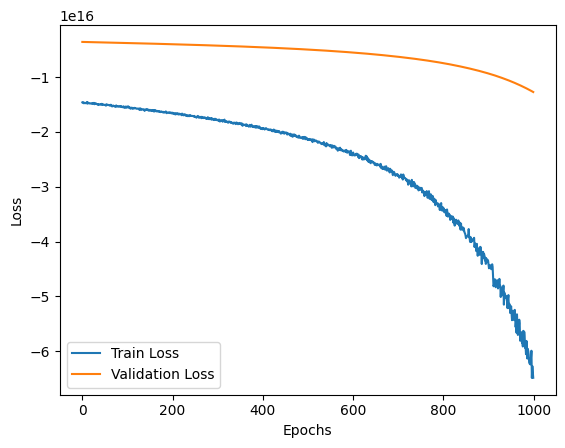

Risk scores: tensor([0.9984, 0.9984, 0.9983, 0.9984, 0.9984, 0.9984, 0.9984, 0.9983, 0.9983,
        0.9984, 0.9984, 0.9984, 0.9984, 0.9983, 0.9983, 0.9983, 0.9984, 0.9983,
        0.9983, 0.9984, 0.9983, 0.9984, 0.9983, 0.9983, 0.9984, 0.9984, 0.9984,
        0.9984, 0.9983, 0.9983, 0.9984, 0.9984, 0.9984, 0.9984, 0.9984, 0.9984,
        0.9984, 0.9983, 0.9984, 0.9983, 0.9984, 0.9984, 0.9984, 0.9984, 0.9984,
        0.9983, 0.9984, 0.9984, 0.9984, 0.9984, 0.9983, 0.9984, 0.9984, 0.9984,
        0.9983, 0.9984, 0.9983, 0.9984, 0.9984, 0.9984, 0.9983, 0.9984, 0.9983,
        0.9983, 0.9984, 0.9983, 0.9984, 0.9984, 0.9983, 0.9983, 0.9983, 0.9984,
        0.9983, 0.9984, 0.9983, 0.9984, 0.9983, 0.9984, 0.9984, 0.9984, 0.9983,
        0.9984, 0.9983, 0.9983, 0.9984, 0.9984, 0.9983, 0.9983, 0.9984, 0.9984,
        0.9983, 0.9984, 0.9984, 0.9984, 0.9983, 0.9984, 0.9983, 0.9984, 0.9984,
        0.9983, 0.9984, 0.9984, 0.9983, 0.9984, 0.9984, 0.9984, 0.9984, 0.9984,
        0.9983, 0.9983, 0.9

In [23]:
# Define the model structure
structure = [
    {'input_dim': 10, 'num_units': 64, 'activation': 'relu'},
    {'input_dim': 64, 'num_units': 32, 'activation': 'relu'}
]

# Instantiate the model
model = NeuralMultiTaskModel(structure, bins=100)

# Generate synthetic data
np.random.seed(42)
torch.manual_seed(42)

X_train = np.random.rand(1000, 10).astype(np.float32)
T_train = np.random.rand(1000, 200).astype(np.float32)  # Adjust this according to your actual data
Triangle = torch.rand((100, 100), dtype=torch.float32)  # Example Triangle matrix

X_train_tensor = torch.tensor(X_train)
Y_train_tensor = torch.tensor(T_train)

# Train the model
model.fit(
    X=X_train_tensor,  # Input features
    T=Y_train_tensor,  # Combined survival times and events
    Triangle=Triangle,  # Example Triangle matrix
    epochs=1000,
    batch_size=32,
    lr=1e-5,
    validation_split=0.2
)

# Predict and evaluate
risk = model.evaluate(X_train_tensor, Y_train_tensor, Triangle)
print("Risk scores:", risk)


# train


In [38]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim

# Define the model
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, dropout=0.2):
        super(NeuralNet, self).__init__()
        layers = []
        in_dim = input_dim
        for layer in hidden_layers:
            layers.append(nn.Linear(in_dim, layer['num_units']))
            if layer['activation'] == 'ReLU':
                layers.append(nn.ReLU())
            elif layer['activation'] == 'Tanh':
                layers.append(nn.Tanh())
            # Add more activations as needed
            layers.append(nn.Dropout(dropout))
            in_dim = layer['num_units']
        layers.append(nn.Linear(in_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define custom MTLR model with the correct loss function
class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True):
        self.loss_values = []
        self.bins = bins
        self.structure = structure
        self.auto_scaler = auto_scaler
        self.scaler = StandardScaler() if auto_scaler else None

    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        max_time = max(T)
        min_time = 0 if is_min_time_zero else min(T)
        p = extra_pct_time
        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.num_times = len(self.times) - 1
        self.time_buckets = [(self.times[i], self.times[i+1]) for i in range(len(self.times)-1)]

    def compute_XY(self, X, T, E, is_min_time_zero=True, extra_pct_time=0.1):
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]
        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            index = np.argmin([abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets])

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[(index):] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        X_cens, X_uncens = torch.FloatTensor(X_cens), torch.FloatTensor(X_uncens)
        Y_cens, Y_uncens = torch.FloatTensor(Y_cens), torch.FloatTensor(Y_uncens)
        return X_cens, X_uncens, Y_cens, Y_uncens

    def loss_function(self, model, X_cens, X_uncens, Y_cens, Y_uncens, Triangle, l2_reg, l2_smooth):
        score_uncens = model(X_uncens)
        phi_uncens = torch.exp(torch.mm(score_uncens, Triangle))
        reduc_phi_uncens = torch.sum(phi_uncens * Y_uncens, dim=1)

        score_cens = model(X_cens)
        phi_cens = torch.exp(torch.mm(score_cens, Triangle))
        reduc_phi_cens = torch.sum(phi_cens * Y_cens, dim=1)

        z_uncens = torch.exp(torch.mm(score_uncens, Triangle))
        reduc_z_uncens = torch.sum(z_uncens, dim=1)

        z_cens = torch.exp(torch.mm(score_cens, Triangle))
        reduc_z_cens = torch.sum(z_cens, dim=1)

        loss = - (
            torch.sum(torch.log(reduc_phi_uncens)) +
            torch.sum(torch.log(reduc_phi_cens)) -
            torch.sum(torch.log(reduc_z_uncens)) -
            torch.sum(torch.log(reduc_z_cens))
        )

        for w in model.parameters():
            loss += l2_reg * torch.sum(w * w) / 2.
        return loss

    def fit(self, X_train, T_train, E_train, X_val, T_val, E_val,
        init_method='glorot_uniform', optimizer='adam', lr=1e-5,
        num_epochs=1000, dropout=0.5, l2_reg=1e-2, l2_smooth=1e-2,
        batch_normalization=False, bn_and_dropout=True, verbose=True,
        extra_pct_time=0.1, is_min_time_zero=True):
      """
      Fit the estimator with both training and validation sets.
      """
      # Initialize attributes
      self.loss_values = []
      self.val_loss_values = []

      # Extracting data parameters
      nb_units, self.num_vars = X_train.shape
      input_shape = self.num_vars

      # Scaling data
      if self.auto_scaler:
          X_train = self.scaler.fit_transform(X_train)
          X_val = self.scaler.transform(X_val)

      # Build the time axis, time buckets, and output Y for both training and validation
      X_cens_train, X_uncens_train, Y_cens_train, Y_uncens_train = self.compute_XY(X_train, T_train, E_train, is_min_time_zero, extra_pct_time)
      X_cens_val, X_uncens_val, Y_cens_val, Y_uncens_val = self.compute_XY(X_val, T_val, E_val, is_min_time_zero, extra_pct_time)

      # Initialize the model
      model = NeuralNet(input_shape, self.num_times, self.structure, dropout)

      # Create the Triangular matrix
      Triangle = np.tri(self.num_times, self.num_times + 1, dtype=np.float32)
      Triangle = torch.FloatTensor(Triangle)

      # Initialize optimizer (changed here)
      if optimizer == 'adam':
          optimizer = optim.Adam(model.parameters(), lr=lr)
      elif optimizer == 'sgd':
          optimizer = optim.SGD(model.parameters(), lr=lr)
      else:
          raise ValueError(f"Unknown optimizer: {optimizer}")

      # Training loop
      for epoch in range(num_epochs):
          model.train()  # Set model to training mode

          # Compute training loss
          loss_train = self.loss_function(model, X_cens_train, X_uncens_train, Y_cens_train, Y_uncens_train, Triangle, l2_reg, l2_smooth)
          self.loss_values.append(loss_train.item())

          # Perform a forward pass on the validation data
          model.eval()  # Set model to evaluation mode
          with torch.no_grad():
              loss_val = self.loss_function(model, X_cens_val, X_uncens_val, Y_cens_val, Y_uncens_val, Triangle, l2_reg, l2_smooth)
          self.val_loss_values.append(loss_val.item())

          # Gradient update
          optimizer.zero_grad()
          loss_train.backward()
          optimizer.step()

          # Logging
          if verbose and (epoch % 100 == 0 or epoch == num_epochs - 1):
              print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}')

      self.model = model.eval()
      return self.model

    def plot_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values, label='Training Loss')
        plt.plot(self.val_loss_values, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()




In [43]:
import numpy as np
import torch

# Sample data generation
def generate_sample_data(num_samples=100, num_features=8, num_times=4):
    np.random.seed(42)

    X = np.random.randn(num_samples, num_features)  # Features
    T = np.random.randint(1, num_times + 1, size=num_samples)  # Time to event or censoring time
    E = np.random.randint(0, 2, size=num_samples)  # Censoring indicator (1 = event, 0 = censored)

    return X, T, E

# Split the data into training and validation sets
X, T, E = generate_sample_data(num_samples=100, num_features=5, num_times=10)
X_train, T_train, E_train = X[:80], T[:80], E[:80]
X_val, T_val, E_val = X[80:], T[80:], E[80:]


Epoch 1/1000, Training Loss: 316.1515, Validation Loss: 88.1944
Epoch 101/1000, Training Loss: 302.6908, Validation Loss: 85.6821
Epoch 201/1000, Training Loss: 273.8709, Validation Loss: 83.3040
Epoch 301/1000, Training Loss: 319.5911, Validation Loss: 80.9215
Epoch 401/1000, Training Loss: 270.9138, Validation Loss: 78.7263
Epoch 501/1000, Training Loss: 300.4540, Validation Loss: 76.7095
Epoch 601/1000, Training Loss: 277.3089, Validation Loss: 74.7838
Epoch 701/1000, Training Loss: 266.1288, Validation Loss: 72.9511
Epoch 801/1000, Training Loss: 295.1359, Validation Loss: 71.2898
Epoch 901/1000, Training Loss: 271.0513, Validation Loss: 69.7025
Epoch 1000/1000, Training Loss: 257.2288, Validation Loss: 68.2537


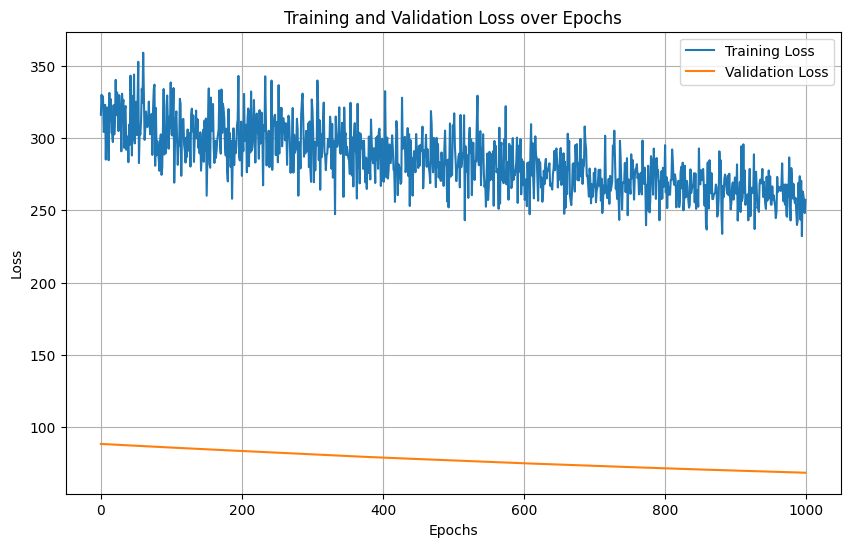

In [44]:
# Create MTLR object with the necessary parameters
structure = [{'activation': 'tanh', 'num_units': 8}]
model = BaseMultiTaskModel(structure=structure, bins=100)

# Fit the model with training and validation data
model.fit(
    X_train=X_train,
    T_train=T_train,
    E_train=E_train,
    X_val=X_val,
    T_val=T_val,
    E_val=E_val,
    num_epochs=1000,
    verbose=True
)

# Plot the training and validation loss curves
model.plot_loss()


# train3

In [17]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Define the model
class NeuralNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_layers, dropout=0.2):
        super(NeuralNet, self).__init__()
        layers = []
        in_dim = input_dim
        for layer in hidden_layers:
            layers.append(nn.Linear(in_dim, layer['num_units']))
            if layer['activation'] == 'ReLU':
                layers.append(nn.ReLU())
            elif layer['activation'] == 'Tanh':
                layers.append(nn.Tanh())
            # Add more activations as needed
            layers.append(nn.Dropout(dropout))
            in_dim = layer['num_units']
        layers.append(nn.Linear(in_dim, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Define the BaseMultiTaskModel
class BaseMultiTaskModel:
    def __init__(self, structure, bins=100, auto_scaler=True):
        self.loss_values = []
        self.val_loss_values = []
        self.bins = bins
        self.structure = structure
        self.scaler = StandardScaler() if auto_scaler else None
        self.auto_scaler = auto_scaler

    def get_times(self, T, is_min_time_zero=True, extra_pct_time=0.1):
        max_time = max(T)
        min_time = 0 if is_min_time_zero else min(T)
        p = extra_pct_time
        self.times = np.linspace(min_time, max_time * (1. + p), self.bins)
        self.num_times = len(self.times) - 1
        self.time_buckets = [(self.times[i], self.times[i+1]) for i in range(len(self.times)-1)]

    def compute_XY(self, X, T, E, is_min_time_zero=True, extra_pct_time=0.1):
        self.get_times(T, is_min_time_zero, extra_pct_time)
        n_units = T.shape[0]
        Y_cens, Y_uncens = [], []
        X_cens, X_uncens = [], []

        for i, (t, e) in enumerate(zip(T, E)):
            y = np.zeros(self.num_times + 1)
            index = np.argmin([abs(a_j_1 - t) for (a_j_1, a_j) in self.time_buckets])

            if e == 1:
                y[index] = 1.
                X_uncens.append(X[i, :].tolist())
                Y_uncens.append(y.tolist())
            else:
                y[(index):] = 1.
                X_cens.append(X[i, :].tolist())
                Y_cens.append(y.tolist())

        X_cens, X_uncens = torch.FloatTensor(X_cens), torch.FloatTensor(X_uncens)
        Y_cens, Y_uncens = torch.FloatTensor(Y_cens), torch.FloatTensor(Y_uncens)
        return X_cens, X_uncens, Y_cens, Y_uncens

    def loss_function(self, model, X_cens, X_uncens, Y_cens, Y_uncens, Triangle, l2_reg, l2_smooth):
        score_uncens = model(X_uncens)
        phi_uncens = torch.exp(torch.mm(score_uncens, Triangle))
        reduc_phi_uncens = torch.sum(phi_uncens * Y_uncens, dim=1)

        score_cens = model(X_cens)
        phi_cens = torch.exp(torch.mm(score_cens, Triangle))
        reduc_phi_cens = torch.sum(phi_cens * Y_cens, dim=1)

        z_uncens = torch.exp(torch.mm(score_uncens, Triangle))
        reduc_z_uncens = torch.sum(z_uncens, dim=1)

        z_cens = torch.exp(torch.mm(score_cens, Triangle))
        reduc_z_cens = torch.sum(z_cens, dim=1)

        loss = - (
            torch.sum(torch.log(reduc_phi_uncens)) +
            torch.sum(torch.log(reduc_phi_cens)) -
            torch.sum(torch.log(reduc_z_uncens)) -
            torch.sum(torch.log(reduc_z_cens))
        )

        for w in model.parameters():
            loss += l2_reg * torch.sum(w * w) / 2.
        return loss

    def fit(self, X_train, T_train, E_train, X_val, T_val, E_val,
        init_method='glorot_uniform', lr=1e-4,
        num_epochs=1000, dropout=0.2, l2_reg=1e-2, l2_smooth=1e-2,
        verbose=True, extra_pct_time=0.1, is_min_time_zero=True):

        self.loss_values = []
        self.val_loss_values = []

        nb_units, self.num_vars = X_train.shape
        input_shape = self.num_vars

        if self.auto_scaler:
            X_train = self.scaler.fit_transform(X_train)
            X_val = self.scaler.transform(X_val)

        X_cens_train, X_uncens_train, Y_cens_train, Y_uncens_train = self.compute_XY(X_train, T_train, E_train, is_min_time_zero, extra_pct_time)
        X_cens_val, X_uncens_val, Y_cens_val, Y_uncens_val = self.compute_XY(X_val, T_val, E_val, is_min_time_zero, extra_pct_time)

        model = NeuralNet(input_shape, self.num_times + 1, self.structure, dropout)

        optimizer = optim.Adam(model.parameters(), lr=lr)

        Triangle = np.tri(self.num_times, self.num_times + 1, dtype=np.float32)
        Triangle = torch.FloatTensor(Triangle)

        for epoch in range(num_epochs):
            model.train()

            loss_train = self.loss_function(model, X_cens_train, X_uncens_train, Y_cens_train, Y_uncens_train, Triangle, l2_reg, l2_smooth)
            self.loss_values.append(loss_train.item())

            model.eval()
            with torch.no_grad():
                loss_val = self.loss_function(model, X_cens_val, X_uncens_val, Y_cens_val, Y_uncens_val, Triangle, l2_reg, l2_smooth)
            self.val_loss_values.append(loss_val.item())

            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

            if verbose and (epoch % 100 == 0 or epoch == num_epochs - 1):
                print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {loss_train.item():.4f}, Validation Loss: {loss_val.item():.4f}')

        self.model = model.eval()
        return self.model

    def plot_loss(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_values, label='Training Loss')
        plt.plot(self.val_loss_values, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss over Epochs')
        plt.legend()
        plt.grid(True)
        plt.show()

# Sample data generation
def generate_sample_data(num_samples=100, num_features=5, num_times=10):
    np.random.seed(42)

    X = np.random.randn(num_samples, num_features)  # Features
    T = np.random.randint(1, num_times + 1, size=num_samples)  # Time to event or censoring time
    E = np.random.randint(0, 2, size=num_samples)  # Censoring indicator (1 = event, 0 = censored)

    return X, T, E

# Split the data into training and validation sets
X, T, E = generate_sample_data(num_samples=100, num_features=5, num_times=10)
X_train, T_train, E_train = X[:80], T[:80], E[:80]
X_val, T_val, E_val = X[80:], T[80:], E[80:]

# Create MTLR object with the necessary parameters
structure = [{'activation': 'ReLU', 'num_units': 128}]
model = BaseMultiTaskModel(structure=structure, bins=100)

# Fit the model with training and validation data
model.fit(
    X_train=X_train,
    T_train=T_train,
    E_train=E_train,
    X_val=X_val,
    T_val=T_val,
    E_val=E_val,
    num_epochs=1000,
    verbose=True
)

# Plot the training and validation loss curves
model.plot_loss()


RuntimeError: mat1 and mat2 shapes cannot be multiplied (34x100 and 99x100)